In [7]:
import geopandas as gpd
from shapely.ops import unary_union
import folium
import leafmap.foliumap as leafmap

In [9]:

# Read GDB layers
gdb_path = "Primary School.gdb.zip"
primary_schools = gpd.read_file(gdb_path, layer='Primary_school_point')
roads = gpd.read_file(gdb_path, layer='Road')
wards = gpd.read_file(gdb_path, layer='Ward_boundary')
rivers = gpd.read_file(gdb_path, layer='River')

In [11]:
municipal_boundary = wards.unary_union
municipal_boundary_gdf = gpd.GeoDataFrame(geometry=[municipal_boundary], crs=wards.crs)

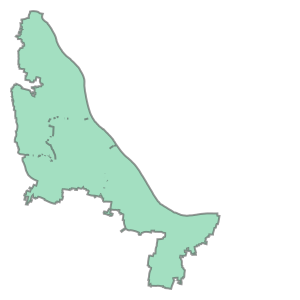

In [12]:
municipal_boundary

In [13]:
municipal_boundary_gdf

,geometry
0,"POLYGON ((441611.903 2542953.353, 441622.994 2..."


In [15]:
BUFFER_DISTANCE = 500  # meters
PROPOSE_SCHOOLS = 3

In [16]:
# Create buffers around schools
school_buffers = primary_schools.buffer(BUFFER_DISTANCE)
served_area = unary_union(school_buffers)
served_area_gdf = gpd.GeoDataFrame(geometry=[served_area], crs=wards.crs)


In [17]:
# Calculate over-served area (intersections of multiple buffers)
overserved_areas = []
for i, buf1 in enumerate(school_buffers):
    for j, buf2 in enumerate(school_buffers):
        if i >= j:
            continue
        inter = buf1.intersection(buf2)
        if not inter.is_empty:
            overserved_areas.append(inter)
overserved_union = unary_union(overserved_areas) if overserved_areas else None

# Calculate underserved area
underserved_area = municipal_boundary.difference(served_area)

# Calculate ward-wise coverage
wards['served_area'] = wards.geometry.intersection(served_area).area
wards['served_percent'] = wards['served_area'] / wards.geometry.area * 100
underserved_wards = wards[wards['served_percent'] < 50]
proposed_locations = underserved_wards.sort_values('served_percent').head(PROPOSE_SCHOOLS).geometry.centroid

In [18]:
m = leafmap.Map(center=[primary_schools.geometry.y.mean(), primary_schools.geometry.x.mean()], zoom=14)

# Add municipal boundary
m.add_gdf(municipal_boundary_gdf, layer_name="Municipal Boundary", style={"color": "black", "weight": 2})

# Add served area
m.add_gdf(served_area_gdf, layer_name=f"{BUFFER_DISTANCE}m Buffer Zone", style={"color": "green", "fillOpacity": 0.2})

# Add primary schools
m.add_gdf(primary_schools, layer_name="Primary Schools", style={"color": "blue"})

# Add proposed schools
proposed_gdf = gpd.GeoDataFrame(geometry=proposed_locations, crs=wards.crs)
m.add_gdf(proposed_gdf, layer_name="Proposed Schools", style={"color": "red", "radius": 10})

# Optional: add ward boundaries
m.add_gdf(wards, layer_name="Ward Boundaries", style={"color": "gray", "weight": 1})

# Optional: add rivers or roads
# m.add_gdf(rivers, layer_name="Rivers", style={"color": "blue"})
# m.add_gdf(roads, layer_name="Roads", style={"color": "orange"})

m.add_layer_control()
m


In [19]:
m.save("primary_school_map.html")